In [6]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-6-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
florida_news = pd.read_csv('data/mediacloud_florida.csv')
print(florida_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4087 entries, 0 to 4086
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  4087 non-null   object
 1   article_url   4087 non-null   object
 2   id            4087 non-null   int64 
 3   language      4087 non-null   object
 4   media_name    4087 non-null   object
 5   media_url     4087 non-null   object
 6   publish_date  4087 non-null   object
 7   title         4087 non-null   object
 8   url           4087 non-null   object
dtypes: int64(1), object(8)
memory usage: 287.5+ KB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(florida_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 4087/4087 [00:00<00:00, 895009.68it/s]


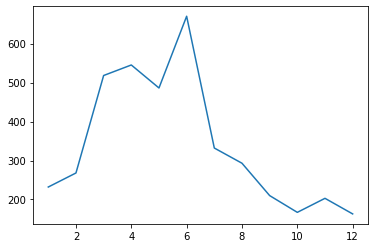

In [7]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [8]:
florida_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
4067,en,wmnf.org,http://wmnf.org,2023-05-23 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Tuesday, May 23, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-tuesday-may-23-2023/
4068,en,wmnf.org,http://wmnf.org,2023-04-12 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Wednesday, April 12th, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-wednesday-april-12th-2023/
4069,en,wmnf.org,http://wmnf.org,2023-04-19 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Wednesday, April 19th, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-wednesday-april-19th-2023/
4070,en,wmnf.org,http://wmnf.org,2023-06-07 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Wednesday, June 7th, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-wednesday-june-7th-2023/
4071,en,wmnf.org,http://wmnf.org,2023-05-10 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Wednesday, May 10th, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-wednesday-may-10th-2023/
4072,en,wmnf.org,http://wmnf.org,2023-05-03 00:00:00,"The Scoop: WMNF’s daily digest of news headlines for Wednesday, May 3rd, 2023",https://www.wmnf.org/the-scoop-wmnfs-daily-digest-of-news-headlines-for-wednesday-may-3rd-2023/
4073,en,wmnf.org,http://wmnf.org,2023-06-26 00:00:00,These new Florida laws will take effect on Saturday: from vouchers to guns,https://www.wmnf.org/these-new-florida-laws-will-take-effect-on-saturday-from-vouchers-to-guns/
4074,en,wmnf.org,http://wmnf.org,2023-08-24 00:00:00,"Trans people want to leave Florida because of anti-LGBTQ+ laws, survey shows",https://www.wmnf.org/trans-people-want-to-leave-florida-because-of-anti-lgbtq-laws-survey-shows/
4075,en,wmnf.org,http://wmnf.org,2023-09-29 00:00:00,"Transgender and nonbinary people sue Florida over its ""discriminatory"" bathroom law",https://www.wmnf.org/transgender-nonbinary-people-sue-florida-over-its-discriminatory-bathroom-law/
4076,en,wmnf.org,http://wmnf.org,2023-12-13 00:00:00,Trial begins in a constitutional challenge to Florida restrictions on medical treatments for transgender people,https://www.wmnf.org/trial-begins-constitutional-challenge-florida-restrictions-medical-treatments-transgender-people/


In [9]:
relevant_news = florida_news[~florida_news['media_name'].isin(['foxnews.com',
                                                               'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4079 entries, 0 to 4086
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    4079 non-null   object
 1   publish_date  4079 non-null   object
 2   title         4079 non-null   object
 3   url           4079 non-null   object
dtypes: object(4)
memory usage: 159.3+ KB
None


In [10]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4079 entries, 0 to 4086
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    4079 non-null   object        
 1   publish_date  4079 non-null   datetime64[ns]
 2   title         4079 non-null   object        
 3   url           4079 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 159.3+ KB
None


In [11]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [12]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 4079/4079 [1:09:41<00:00,  1.03s/it]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4079 entries, 0 to 4086
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    4079 non-null   object        
 1   publish_date  4079 non-null   datetime64[ns]
 2   title         4079 non-null   object        
 3   url           4079 non-null   object        
 4   subtitle      3087 non-null   object        
 5   text          3563 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 223.1+ KB
None


In [13]:
relevant_news.to_csv('data/florida_article_texts_and_info.csv',
                     index=False)